In [412]:
import numpy as np
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math
import skimage
import time

In [413]:
def read_images(image_path):
    img = cv2.imread(image_path)
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float)/255
    return img

### Scale Space by increasing Sigma

In [414]:
def  generate_scale_space(image, initial_sigma, constant_multiplier, iterations):
    current_sigma = initial_sigma
    height = image.shape[0]
    width = image.shape[1]
    scale_space = np.empty((height, width, iterations))
    sigma_values = []
    for i in range(0, iterations):
        sigma_values.append(current_sigma)
        LoG_response = ndimage.gaussian_laplace(image, current_sigma,mode="nearest")
        sigma_normalized_LoG =  np.square(current_sigma) * LoG_response
        scale_space[:,:,i] = np.square(sigma_normalized_LoG)
        current_sigma = math.ceil(constant_multiplier * current_sigma)

    return scale_space

### Scale Space by Downsizing Image


In [415]:
def  generate_constant_scale_space(image, initial_sigma, constant_multiplier, iterations):
    current_sigma = initial_sigma
    height = image.shape[0]
    width = image.shape[1]
    scale_space = np.empty((height, width, iterations))
    factor = 1
    sigma_values = []
    for i in range(0, iterations):
        sigma_values.append(current_sigma)
        LoG_response = ndimage.gaussian_laplace(skimage.transform.resize(image, (image.shape[0]//factor,  image.shape[1]//factor), anti_aliasing=True), current_sigma,mode="nearest")
        sigma_normalized_LoG =  np.square(current_sigma) * LoG_response
        scale_space[:,:,i] = np.square(skimage.transform.resize(sigma_normalized_LoG, (image.shape[0],  image.shape[1])))
        factor = factor * constant_multiplier
    return scale_space

#### Suppress across 2D slices and 3D scale space

In [416]:
def non_maximum_suppression(scale_space, window_size):
    suppressed_space = ndimage.rank_filter(scale_space,rank=-1, footprint=np.ones((window_size,window_size,1)))
    suppressed_space = scale_space * (np.array(suppressed_space == scale_space).astype(int))
    return suppressed_space

def non_maximum_sup_scale_space(scale_space):
    suppressed_space = np.empty((scale_space.shape[0],scale_space.shape[1],scale_space.shape[2]))
    for i in range(scale_space.shape[2]):
         y = ndimage.rank_filter(scale_space[:,:,max(0,i-2):min(scale_space.shape[2],i+3)], rank=-1, size=(13,13,min(scale_space.shape[2],i+3)-max(0,i-2)+1))
         suppressed_space[:,:,i] = y[:,:,-1]

    new_suppressed_scale_space = scale_space *  (np.array(suppressed_space == scale_space).astype(int))

    return new_suppressed_scale_space

#### Apply scale space blob detection logic

In [417]:
def apply_scale_space_logic(img, initial_sigma, constant_scale_factor, iterations):
    scale_space = generate_scale_space(img , initial_sigma, constant_scale_factor, 12 )
    suppressed_responses = non_maximum_suppression(scale_space, suppress_window)
    suppressed_sp = non_maximum_sup_scale_space(suppressed_responses)
    return suppressed_sp

def apply_constant_scale_space_logic(img, initial_sigma, constant_scale_factor, iterations):
    scale_space = generate_constant_scale_space(img , initial_sigma, constant_scale_factor, 12 )
    suppressed_responses = non_maximum_suppression(scale_space, suppress_window)
    suppressed_sp = non_maximum_sup_scale_space(suppressed_responses)
    return suppressed_sp

In [418]:
def get_coordinates(img_space, threshold):
    coordinates = np.where(img_space > threshold)
    return coordinates[0],coordinates[1],coordinates[2]

In [419]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, (pow(constant_scale_factor,rad) * initial_sigma)):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

In [420]:
constant_scale_factor = 1.25
initial_sigma = 2
suppress_window = 5
threshold = .0109
iterations = 10
#

time taken 0.6038250923156738


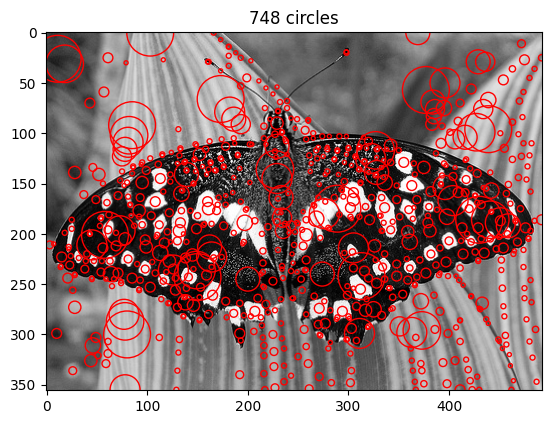

In [421]:
image_path = 'butterfly.jpg'
img = read_images(image_path)

start = time.time()
scale_space = apply_scale_space_logic(img, initial_sigma, constant_scale_factor,iterations)
end = time.time()

print("time taken inefficient method:",end - start)
y, x, rad = get_coordinates(scale_space, threshold)
show_all_circles(img,x, y, rad)

Time taken efficient method: 0.3054931163787842


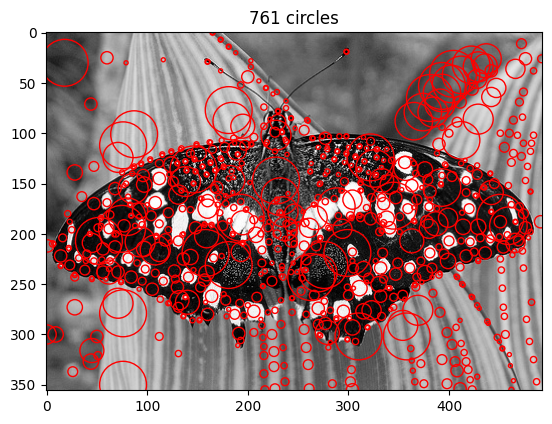

In [424]:
start = time.time()
scale_space = apply_constant_scale_space_logic(img, initial_sigma, constant_scale_factor,iterations)
end = time.time()

print("Time taken efficient method:",end - start)
y, x, rad = get_coordinates(scale_space, threshold)
show_all_circles(img,x, y, rad)